# Kernels

revision: 78571a2

In [39]:
# @formatter:off
# PREAMBLE

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import check_grad

%matplotlib inline
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")
%load_ext autoreload
%autoreload 2
# @formatter:on

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Kernel Ridge Regression

X.shape = (1826, 1)
y.shape = (1826,)


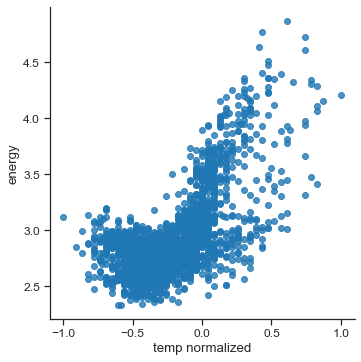

In [40]:
# load the data
df = pd.read_csv('energy.csv', sep=' ')
# normalize
df['temp normalized'] = 2 * (df['temp'] - df['temp'].min()) / (df['temp'].max() - df['temp'].min()) - 1
sns.lmplot(x='temp normalized', y='energy', data=df, fit_reg=False)

# load the data
X = df['temp normalized'].values.reshape((-1, 1))
y = df['energy'].values
m, n = X.shape

print(f'X.shape = {X.shape}')
print(f'y.shape = {y.shape}')

First, we create a function that calculates squared exponential kernel, i.e.
$$
	k(x,z) = \exp \Big( -\frac{ \lVert x-z \rVert^2}{2\sigma^2} \Big)
$$
We do this is two steps. First, we create function `sq_dist(X, Z)` which calculates the squared euclidean distance $\lVert x-z \rVert^2$ between all pairs of inputs
$$
	X = \begin{bmatrix}
		~-~ \vec{x}_1^{\intercal} ~-~~ \\
		~-~ \vec{x}_2^{\intercal} ~-~~ \\
		\vdots                                       \\
		~-~ \vec{x}_m^{\intercal} ~-~~ \\
	\end{bmatrix}
\quad\text{and}\quad
	Z = \begin{bmatrix}
		~-~ \vec{x}_1^{\intercal} ~-~~ \\
		~-~ \vec{x}_2^{\intercal} ~-~~ \\
		\vdots                                       \\
		~-~ \vec{x}_l^{\intercal} ~-~~ \\
	\end{bmatrix}
$$
Notice, that both design matrices can have a different number of rows.

In [41]:
# Open kernels.py and implement the function sq_dist

from mlis.kernels.kernels import sq_dist

X = np.array([[1, 2, -1], [3, 2, 1]])
Z = np.array([[5, 1, 5]])
# test shape
np.testing.assert_array_equal(sq_dist(X, Z).shape, (2, 1))
np.testing.assert_array_almost_equal(sq_dist(X, Z), [[53], [21]], decimal=3)


Now implement squared exponential kernel:
$$
	k(x,z) = \exp \Big( -\frac{\text{sq_dist}(x,z)}{2\sigma^2} \Big)
$$

The function `sq_exp(X,Z,sigma)` should return the kernel matrix $K$ with $K_{ij}=k(x_i,z_j)$

In [42]:
# Open kernels.py and implement the function sq_exp

from mlis.kernels.kernels import sq_exp

sigma = 10
X = np.array([[1, 2, -1], [3, 2, 1]])
Z = np.array([[5, 1, 5]])
# test shape
np.testing.assert_array_equal(sq_exp(X, Z, sigma).shape, (2, 1))
np.testing.assert_array_almost_equal(sq_exp(X, Z, sigma), [[0.767], [0.9]], decimal=3)

Implement kernel ridge regression algorithm. It has a close form solution, which is
$$
\alpha^\star = (K+\lambda I)^{-1} y,
$$

In [43]:
# Open kernel_ridge_regression.py and implement the function kernel_ridge

from mlis.kernels.kernel_ridge_regression import kernel_ridge

sigma = 10
lam = 1
X = np.array([[1, 2, -1], [3, 2, 1]])
Z = np.array([[1, 1, -1], [2, -2, -1], [.1, -3, 1]])
y = np.array([1, 2])
h = kernel_ridge(X, y, sigma, lam)

np.testing.assert_array_almost_equal(h(Z), [0.97, 0.913, 0.858], decimal=3)

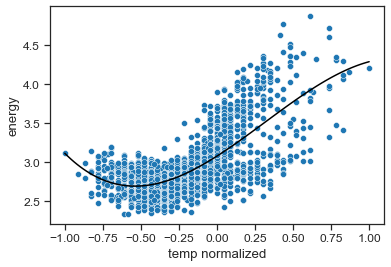

In [44]:
def plot_fit(h, ax=None):
    x = np.linspace(df['temp normalized'].min(), df['temp normalized'].max(), 100).reshape((-1, 1))
    y = np.squeeze(h(x))
    if ax is None:
        fig, ax = plt.subplots()

    sns.scatterplot(ax=ax, x='temp normalized', y='energy', data=df)
    ylim = ax.get_ylim()
    ax.plot(x, y, 'k', label='Prediction')
    ax.set_ylim(ylim)


# load the data
X = df['temp normalized'].values.reshape((-1, 1))
y = df['energy'].values

plot_fit(kernel_ridge(X, y, sigma=10, lam=1e-6))

Reproduce figure 5.1 on page 50

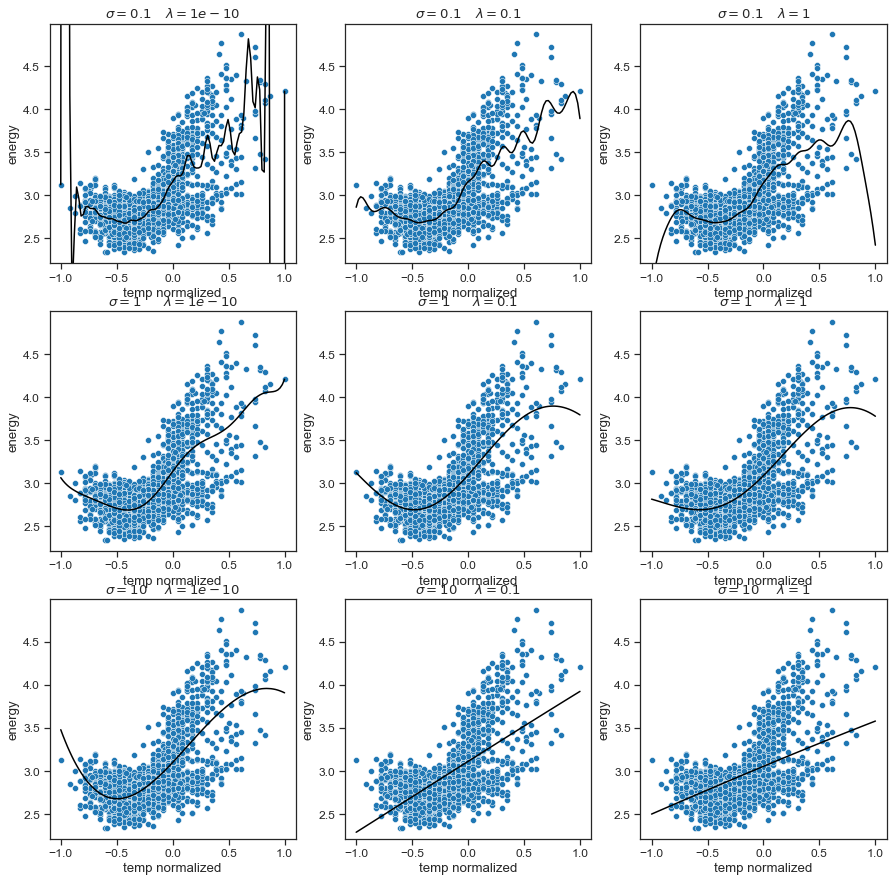

In [45]:
sigmas = [0.1, 1, 10]
lambdas = [1e-10, 0.1, 1]

fig, axs = plt.subplots(len(sigmas), len(lambdas), figsize=(15, 15))
for i, sigma in enumerate(sigmas):
    for j, lam in enumerate(lambdas):
        plot_fit(kernel_ridge(X, y, sigma, lam), ax=axs[i, j])
        axs[i, j].set_title(f'$\sigma={sigma}$\t$\lambda={lam}$')

### Kernel Logistic Regression

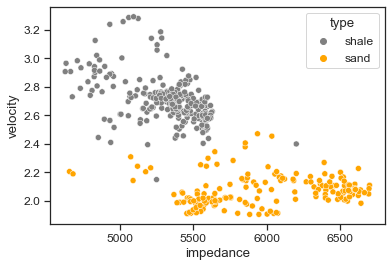

In [46]:
from sklearn import preprocessing

df = pd.read_csv('rocktypes.csv', sep=' ')
df['label'] = df['type'].apply(lambda string: -1 if string == 'sand' else +1)


def plot_fit(h=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    sns.scatterplot(ax=ax, x='impedance', y='velocity', hue='type', data=df, palette=dict(sand='orange', shale='gray'))
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    scaler = preprocessing.StandardScaler().fit(df[['impedance', 'velocity']].values)
    if h:
        grid = 150
        xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], grid), np.linspace(ylim[0], ylim[1], grid))
        XY = np.array([np.ravel(xx), np.ravel(yy)]).T
        XY = scaler.transform(XY)
        P = h(XY).reshape(grid, grid)
        cn = ax.contour(xx, yy, P, colors='k', levels=10)
        ax.clabel(cn, inline=1, fontsize=10)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


plot_fit()

Implement the regularized kernlized logistic regression objective, give by

$$
J(\alpha) = \frac{1}{m}\sum_{i=1}^m  \log \big(1 + \exp\big(-y \cdot \sum_{j=1}^{m} \alpha_j k(x_j,x_j)\big) \big) + \lambda \alpha^{\intercal}K\alpha
$$

using the squared exponential kernel.


In [147]:
# Open kernel_logistic_regression.py and implement the function J

from mlis.kernels.kernel_logistic_regression import J

sigma = 10
lam = 1
X = np.array([[1, 2, -1], [3, 2, 1]])
α = np.array([1, -1])
y = np.array([1, 2])

np.testing.assert_array_almost_equal(J(α, X, y, sigma, lam), 0.782, decimal=3)

Implement the gradient of the regularized kernelized logistic regression objective.

In [175]:
# Open kernel_logistic_regression.py and implement the function dJ

from mlis.kernels.kernel_logistic_regression import dJ

sigma = 10
lam = 1
X = np.array([[1, 2, -1], [3, 2, 1]])
α = np.array([1, -1])
y = np.array([1, 2])

np.testing.assert_allclose(check_grad(J, dJ, α, X, y, sigma, lam), 0.0, atol=1e-3) # atol=1e-4

In [176]:
# Open kernel_logistic_regression.py and implement the function kernel_lr

from mlis.kernels.kernel_logistic_regression import kernel_lr

sigma = 10
lam = 1
X = np.array([[1, 2, -1], [3, 2, 1]])
Z = np.array([[1, 1, -1], [2, -2, -1], [.1, -3, 1]])
y = np.array([1, 2])
h = kernel_lr(X, y, sigma, lam)
np.testing.assert_array_almost_equal(h(Z), [0.28, 0.262, 0.246], decimal=2) # decimal=2

d:\docs\uni\ws22\Introduction to Machine Learning\PM04\mlis\kernels\kernel_logistic_regression.py:45: RuntimeWarning: overflow encountered in exp
  @param X: data matrix with x_i^T in the ith row


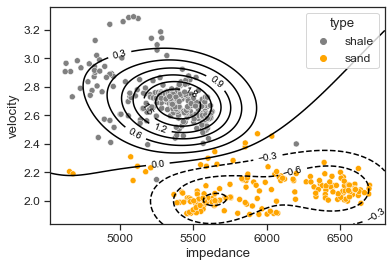

In [177]:
X = df[['impedance', 'velocity']].values
y = df['type'].apply(lambda string: -1 if string == 'sand' else +1).values
# normalize data using scipy
X = preprocessing.StandardScaler().fit_transform(X)

h = kernel_lr(X, y, sigma=0.5, lam=0.01)
plot_fit(h)

Reproduce figure 5.2 on page 51

d:\docs\uni\ws22\Introduction to Machine Learning\PM04\mlis\kernels\kernel_logistic_regression.py:45: RuntimeWarning: overflow encountered in exp
  @param X: data matrix with x_i^T in the ith row
d:\docs\uni\ws22\Introduction to Machine Learning\PM04\mlis\kernels\kernel_logistic_regression.py:45: RuntimeWarning: overflow encountered in exp
  @param X: data matrix with x_i^T in the ith row
d:\docs\uni\ws22\Introduction to Machine Learning\PM04\mlis\kernels\kernel_logistic_regression.py:45: RuntimeWarning: overflow encountered in exp
  @param X: data matrix with x_i^T in the ith row
d:\docs\uni\ws22\Introduction to Machine Learning\PM04\mlis\kernels\kernel_logistic_regression.py:45: RuntimeWarning: overflow encountered in exp
  @param X: data matrix with x_i^T in the ith row
d:\docs\uni\ws22\Introduction to Machine Learning\PM04\mlis\kernels\kernel_logistic_regression.py:45: RuntimeWarning: overflow encountered in exp
  @param X: data matrix with x_i^T in the ith row
d:\docs\uni\ws22\Int

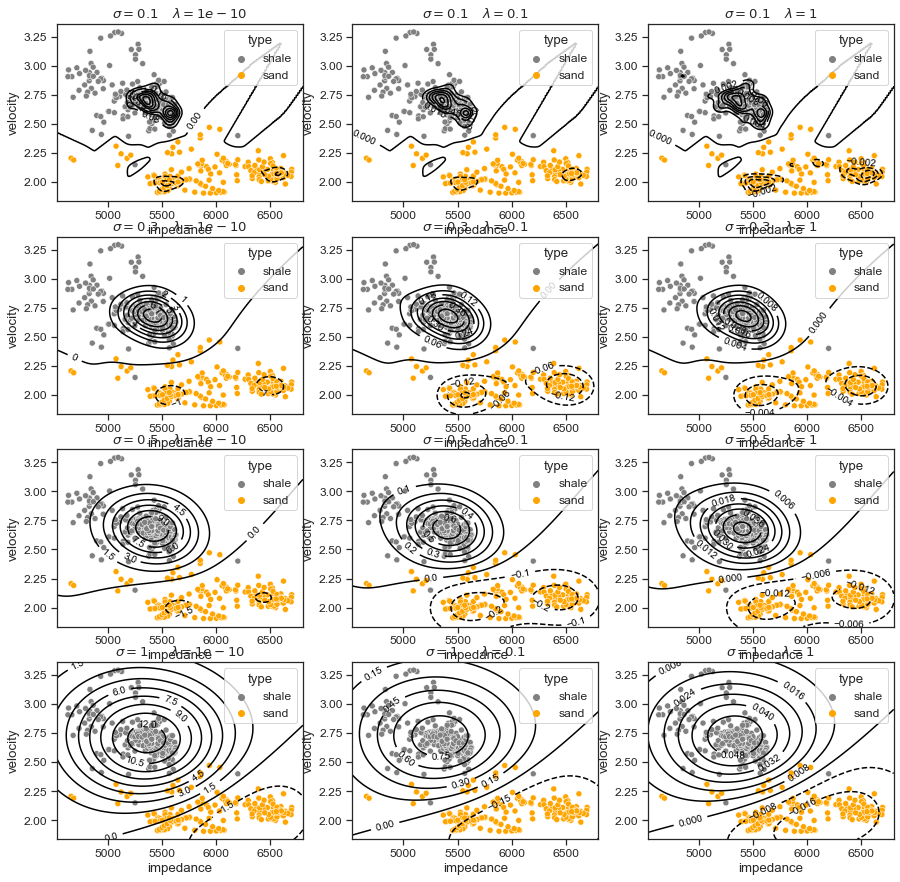

In [178]:
sigmas = [0.1, .3, .5, 1]
lambdas = [1e-10, 0.1, 1]

fig, axs = plt.subplots(len(sigmas), len(lambdas), figsize=(15, 15))
for i, sigma in enumerate(sigmas):
    for j, lam in enumerate(lambdas):
        plot_fit(kernel_lr(X, y, sigma, lam), ax=axs[i, j])
        axs[i, j].set_title(f'$\sigma={sigma}$\t$\lambda={lam}$')